# Market Basket Analysis using PySpark




In [26]:
!pip install pyspark
!pip install pyspark_dist_explore

## Importing libraries



In [27]:
from pyspark import SparkContext
from pyspark.sql import functions as f, SparkSession, Column
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.ml.fpm import FPGrowth



## Create a spark session



In [28]:
spark = SparkSession.builder \
    .appName("arlUsingPyspark") \
    .getOrCreate()

# Read the data


In [29]:
df1 = spark.read.csv("basket.csv", header=True).withColumn("id", f.monotonically_increasing_id())
df2 = spark.read.csv("Groceries data.csv", header=True).withColumn("id", f.monotonically_increasing_id())

In [30]:

df1.show(5)
df2.show(5)

+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
|          0|                 1|                  2|     3|   4|   5|   6|   7|   8|   9|  10| id|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
| whole milk|            pastry|        salty snack|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  0|
|    sausage|        whole milk|semi-finished bread|yogurt|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  1|
|       soda|pickled vegetables|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  2|
|canned beer|   misc. beverages|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  3|
|    sausage|  hygiene articles|               NULL|  NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|  4|
+-----------+------------------+-------------------+------+----+----+----+----+----+----+----+---+
only showing top 5 rows

+-------------+----------+----------------+----+-----+---+-----------+---+
|Member_n

In [31]:
# printSchema() shows the structure of the dataframe.
df1.printSchema()
df2.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- 2: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- 4: string (nullable = true)
 |-- 5: string (nullable = true)
 |-- 6: string (nullable = true)
 |-- 7: string (nullable = true)
 |-- 8: string (nullable = true)
 |-- 9: string (nullable = true)
 |-- 10: string (nullable = true)
 |-- id: long (nullable = false)

root
 |-- Member_number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- id: long (nullable = false)



# Baskets per customer



In [32]:
num_baskets = df2.groupBy("Member_number").count()
num_baskets.show(5)

+-------------+-----+
|Member_number|count|
+-------------+-----+
|         2904|   10|
|         3959|   14|
|         2294|   23|
|         4032|    4|
|         1512|   10|
+-------------+-----+
only showing top 5 rows



# The distribution of the number of baskets



(array([302., 328., 178., 371., 237., 341., 251., 538., 252., 192., 179.,
        144., 136., 109.,  69., 110.,  49.,  23.,  29.,  14.,  11.,   9.,
         13.,   4.,   1.,   4.,   0.,   3.,   0.,   1.]),
 array([ 2.        ,  3.13333333,  4.26666667,  5.4       ,  6.53333333,
         7.66666667,  8.8       ,  9.93333333, 11.06666667, 12.2       ,
        13.33333333, 14.46666667, 15.6       , 16.73333333, 17.86666667,
        19.        , 20.13333333, 21.26666667, 22.4       , 23.53333333,
        24.66666667, 25.8       , 26.93333333, 28.06666667, 29.2       ,
        30.33333333, 31.46666667, 32.6       , 33.73333333, 34.86666667,
        36.        ]),
 <BarContainer object of 30 artists>)

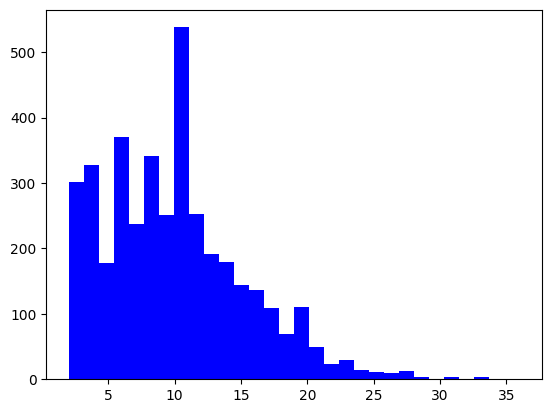

In [33]:
fig, ax = plt.subplots()

hist(ax, num_baskets.select('count'), bins = 30, color=['blue'])

#  implementation of FPGrowth



In [34]:
df_basket = df1.select("id", f.array([df1[c] for c in df1.columns[:11]]).alias("basket"))
df_basket.printSchema()
df_basket.show(3, False)

root
 |-- id: long (nullable = false)
 |-- basket: array (nullable = false)
 |    |-- element: string (containsNull = true)

+---+--------------------------------------------------------------------------------------------+
|id |basket                                                                                      |
+---+--------------------------------------------------------------------------------------------+
|0  |[whole milk, pastry, salty snack, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]           |
|1  |[sausage, whole milk, semi-finished bread, yogurt, NULL, NULL, NULL, NULL, NULL, NULL, NULL]|
|2  |[soda, pickled vegetables, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL]            |
+---+--------------------------------------------------------------------------------------------+
only showing top 3 rows



### Remove null values

In [35]:
df_aggregated = df_basket.select("id", f.array_except("basket", f.array(f.lit(None))).alias("basket"))
df_aggregated.show(3, False)

+---+--------------------------------------------------+
|id |basket                                            |
+---+--------------------------------------------------+
|0  |[whole milk, pastry, salty snack]                 |
|1  |[sausage, whole milk, semi-finished bread, yogurt]|
|2  |[soda, pickled vegetables]                        |
+---+--------------------------------------------------+
only showing top 3 rows



## Hyperparameters

* minSupport - The minimum support of an item to be considered in a frequent itemset.
* minConfidence - The minimum confidence for generating an association rule from an itemset.
* numPartitions - The number of partitions used to distribute the work. This is Spark-specific.



In [36]:
fp = FPGrowth(minSupport=0.001, minConfidence=0.001, itemsCol='basket', predictionCol='prediction')
model = fp.fit(df_aggregated)

In [37]:

model.freqItemsets.show(10, False)

+------------------------+----+
|items                   |freq|
+------------------------+----+
|[cocoa drinks]          |16  |
|[canned fruit]          |21  |
|[specialty cheese]      |72  |
|[chocolate marshmallow] |60  |
|[pet care]              |85  |
|[house keeping products]|45  |
|[jam]                   |34  |
|[light bulbs]           |29  |
|[beef]                  |508 |
|[beef, frankfurter]     |15  |
+------------------------+----+
only showing top 10 rows



In [38]:
# Show the rules
model.associationRules.filter(model.associationRules.confidence>0.15).show(20, False)

+---------------------+------------+-------------------+------------------+---------------------+
|antecedent           |consequent  |confidence         |lift              |support              |
+---------------------+------------+-------------------+------------------+---------------------+
|[bottled beer]       |[whole milk]|0.15781710914454278|0.9993302598941151|0.007150972398583172 |
|[detergent]          |[whole milk]|0.16279069767441862|1.030824041177455 |0.001403461872619127 |
|[semi-finished bread]|[whole milk]|0.176056338028169  |1.1148247930239072|0.001670787943594199 |
|[sausage, rolls/buns]|[whole milk]|0.2125             |1.345593525179856 |0.0011361358016440553|
|[sausage, soda]      |[whole milk]|0.1797752808988764 |1.1383739010113787|0.0010693042839002875|
|[ham]                |[whole milk]|0.16015625         |1.0141421789039358|0.0027400922274944863|
|[frozen fish]        |[whole milk]|0.1568627450980392 |0.9932870312746344|0.0010693042839002875|
|[sausage, whole mil

## Prediction based on the generated association rules


In [39]:
# Create a PySpark dataframe
columns = ['basket']
new_data = [(['ham', 'yogurt', 'light bulbs'],), (['jam', 'cocoa drinks', 'pet care'],)]
rdd = spark.sparkContext.parallelize(new_data)
new_df = rdd.toDF(columns)
new_df.printSchema()
new_df.show(2,False)

root
 |-- basket: array (nullable = true)
 |    |-- element: string (containsNull = true)

+-----------------------------+
|basket                       |
+-----------------------------+
|[ham, yogurt, light bulbs]   |
|[jam, cocoa drinks, pet care]|
+-----------------------------+



# Prediction



In [40]:
model.transform(new_df).show(5, False)

+-----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|basket                       |prediction                                                                                                                                                                                                                                                                                                             